In [2]:
%matplotlib inline
from IPython import display
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

vector_dem=2


# datasize

In [3]:
def child_layer_1(input_layer, n_output):
    conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=32,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)
    
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
    
    conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=32,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)
    
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
    
    pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 32])
    
    dense = tf.layers.dense(inputs=pool2_flat, units=512, activation=tf.nn.relu)
   
    dropout = tf.layers.dropout(inputs=dense, rate=0.4)
    
    dense = tf.layers.dense(inputs=dropout, units=512, activation=tf.nn.relu)

    dropout = tf.layers.dropout(inputs=dense, rate=0.4)

    output_layer = tf.layers.dense(inputs=dropout, units=n_output)
    
    return output_layer


In [4]:

def get_mask(size, n_childs=2): 
    multiple=size/(n_childs*2)+1
    
    Ones = tf.constant(1, dtype="float", shape=[n_childs,n_childs])
    Zeros = tf.constant(0, dtype="float", shape=[n_childs,n_childs])
    
    #(n_childs*2, n_childs*2)
    Pattern = tf.concat([tf.concat([Ones, Zeros], axis=0),tf.concat([Zeros, Ones], axis=0)], axis=1)
    
    return tf.slice(\
                    tf.matrix_band_part(\
                                        tf.tile(\
                                                Pattern,\
                                                [multiple, multiple]),\
                                        n_childs,\
                                        n_childs),\
                    [0,0],\
                    [size,size])
    

In [5]:
def prepare_ax(num):
    n_rows=num/2 if num%2==0 else num/2 + 1
    fig = plt.figure(figsize=(20,6 * n_rows))
    
    ax = [None]*num
    for i in range(num):
        ax[i]=fig.add_subplot(n_rows, 2, i + 1)
    return ax

def draw_ax(ax, data, label, nums):
    for j in range(len(ax)):
        ax[j].cla()
        for i in range(len(nums)):
            ax[j].scatter(data[j][label[:,i]==1,0],data[j][label[:,i]==1,1],s=5,label=str(nums[i]))
            ax[j].legend()
    display.display(plt.gcf())
    display.clear_output(wait=True)

In [16]:
def build_1st_model(n_output, n_childs=2, learning_rate = 1e-5):
    X0 = tf.placeholder("float", [None, 28,28,1])
    X1 = tf.placeholder("float", [None, 28,28,1])

    output_layer=[]
    output_layer.append(child_layer_1(X0, n_output))
    output_layer.append(child_layer_1(X1, n_output))
        

    #(input_batch_size * n_childs, n_output)
    output_concat = tf.reshape(tf.stack(output_layer, axis=1), [-1,n_output])
    #(input_batch_size * n_childs, input_batch_size * n_childs, n_output)
    output_cross_sub=tf.reshape(output_concat, shape=[1, -1, n_output])\
                            -tf.reshape(output_concat, shape=[-1, 1, n_output])
    #(input_batch_size * n_childs, input_batch_size * n_childs)
    output_cross_distance=tf.norm(output_cross_sub, ord='euclidean', axis=2)+1e-6

    mask=get_mask(tf.shape(output_cross_distance)[0], n_childs)

    output_mutual_diatance_same_sample=mask * output_cross_distance
    output_mutual_diatance_same_sample_max=tf.reduce_max(output_mutual_diatance_same_sample, axis=0)

    output_mutual_diatance_diff_sample=(1-mask) * output_cross_distance
    output_mutual_diatance_diff_sample_rescale=output_mutual_diatance_diff_sample/output_mutual_diatance_same_sample_max

    loss=tf.reduce_mean(tf.exp(-tf.square(output_mutual_diatance_diff_sample_rescale)))
    
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    
    return X0,X1, train_step, loss, output_layer
   

In [50]:
from tensorflow.examples.tutorials.mnist import input_data
def prepare_data(nums):
    mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
    # dataset size
    n_train = mnist.train.num_examples # 55,000
    n_validation = mnist.validation.num_examples # 5000
    n_test = mnist.test.num_examples # 10,000
    

    test_data=mnist.test.images
    test_lable=mnist.test.labels

    num_lable=test_lable[:,nums].sum(axis=1)==1
    tx=test_data[num_lable]
    ty=test_lable[num_lable][:,nums]


    train_data=mnist.train.images
    train_lable=mnist.train.labels

    num_lable=train_lable[:,nums].sum(axis=1)==1
    x=train_data[num_lable]
    y=train_lable[num_lable][:,nums]
    
    validate_data=mnist.validation.images
    validate_lable=mnist.validation.labels
    
    num_lable=validate_lable[:,nums].sum(axis=1)==1
    vx=validate_data[num_lable]
    vy=validate_lable[num_lable][:,nums]
    
    return (x, y),(tx, ty),(vx, vy)

def permutation(x, y):
    seq=np.random.permutation(len(x))
    return x[seq], y[seq]

def gen_batch(x, y, batch_size):
    if not len(x)== len(y):
        raise Exception()
    index = 0
    length = len(x)      
    shuffle_x=copy_group_shuffle(x,y)
      
    while True:
        if index + batch_size < length:
            x_batch_0=x[index:index + batch_size]
            x_batch_1=shuffle_x[index:index + batch_size]
            y_batch=y[index:index + batch_size]            
            yield x_batch_0,x_batch_1,y_batch 
            index+=batch_size
        else:
            index=0
            x,y=permutation(x, y)
            shuffle_x=copy_group_shuffle(x,y)
            
def copy_group_shuffle(x,y):
    shuffle_x=np.copy(x)
    tag_y=np.argwhere(y==1)[:,1]
    
    for tag in np.unique(tag_y):
        indexs=(tag_y==tag)
        to_shffle=shuffle_x[indexs]
        
        np.random.shuffle(to_shffle)
        
        shuffle_x[indexs] = to_shffle
    
    return shuffle_x
    

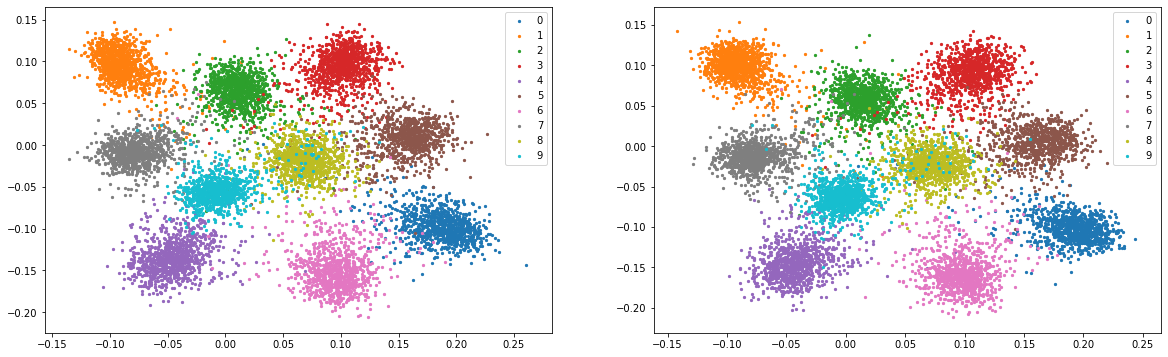

In [54]:
def train_and_save_1st_model(nums, n_iterations, n_output, n_childs ,batch_size=128):
    
       
    # prepare data, with x,y the train data and label, tx,ty the test, vx,vy the validation
    (x, y),(tx, ty),(vx, vy)=prepare_data(nums)
    
    g1 = tf.Graph()
    with g1.as_default():
        X0, X1, train_step, loss, output_layer = build_1st_model(n_output=n_output, n_childs=n_childs)
    
    ax=prepare_ax(n_childs)
    history={'loss':[]}
    with tf.Session(graph=g1) as sess:
        tf.global_variables_initializer().run()
        train_batch_gen=gen_batch(x, y,batch_size)
        model_saver = tf.train.Saver()
        
        for i in range(n_iterations):

            if i%200==0:

                output,Loss = sess.run([output_layer, loss],
                                       feed_dict={X0: tx.reshape((-1,28,28,1)), X1: tx.reshape((-1,28,28,1))})
                print("Iteration", str(i), "\t| Loss =", str(Loss), "\t| debug1 =", 1, "\t |Loss1:", 1, "\t |Loss2:", 1)

                draw_ax(ax, output,ty,nums)
                history['loss'].append(Loss)

            batch_x0, batch_x1, batch_y = next(train_batch_gen)
            
            sess.run(train_step, 
                     feed_dict={X0: batch_x0.reshape((-1,28,28,1)), X1: batch_x1.reshape((-1,28,28,1))})
            model_saver.save(sess, "./ckpt/{}.{}.{}model.ckpt".format(str(len(nums)),str(n_output),str(n_childs))) 
                       
    return history

history_1=train_and_save_1st_model(nums=nums_to_recongnise, n_iterations = 10000, n_output=vector_dem, n_childs=2)
